In [1]:
"""

"""

'\n\n'

In [31]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [3]:
# ==========================================
# parameters

# ------------------------------------------
# mesh
xmin = 0.0
xmax = 1.0
nel = 50000
p_order = 2

# ------------------------------------------
# material system (nondimensional)
d_NonDim = 1.20   # d/H
wl_NonDim = 0.10  # lambda/H
fe_NonDim = 1.0  # lambda*tao/k

d_NonDim = 0.4   # d/H
wl_NonDim = 0.10  # lambda/H
fe_NonDim = 1.0  # lambda*tao/k

d_NonDim = 0.60   # d/H
wl_NonDim = 0.10  # lambda/H
fe_NonDim = 0.50  # lambda*tao/k

d_NonDim = 0.20   # d/H
wl_NonDim = 0.02  # lambda/H
fe_NonDim = 0.0001  # lambda*tao/k

In [4]:
class LoadStepper:

    """
    Time "integrator" for a problem with no time derivatives.  This 
    is basically just to keep track of a parameter, ``self.t``, that
    can be used to parameterize external loading.
    """

    def __init__(self,DELTA_T,t=0.0):
        """
        Initializes the ``LoadStepper`` with a (pseudo)time step ``DELTA_T``
        and initial time ``t``, which defaults to zero.
        """
        self.DELTA_T = DELTA_T
        self.tval = t
        self.t = Expression("t",t=self.tval,degree=0)
        self.advance()

    def advance(self):
        """
        Increments the loading.
        """
        self.tval += float(self.DELTA_T)
        self.t.t = self.tval

In [5]:
# ------------------------------------------
# time stepping
N_STEPS = 50
# N_STEPS = 1
DELTA_T = 1.0/float(N_STEPS)
stepper = LoadStepper(DELTA_T)

In [6]:
# ==========================================
# function bank
def strain(v):
    return grad(v)[0]

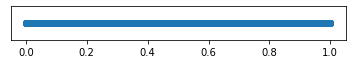

In [7]:
# ==========================================
# mesh
mesh = IntervalMesh(nel, xmin, xmax)

plot(mesh)

class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], xmin, 1.e-14) and on_boundary
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], xmax, 1.e-14) and on_boundary

In [8]:
# This imposes a Dirichlet condition at the point x=0
def Dirichlet_x0_boundary(x,on_boundary):
    tol = 1e-14
    return abs(x[0]-xmin)<tol

# This imposes a Dirichlet condition at the point x=1
def Dirichlet_x1_boundary(x,on_boundary):
    tol = 1e-14
    return abs(x[0]-xmax)<tol

In [9]:
# =========================================
# function space
V1D = FiniteElement('CG',mesh.ufl_cell(),p_order)
# u1 and u2 for the bot and top layers
V   = FunctionSpace(mesh,MixedElement(V1D,V1D))

In [10]:
# =========================================
# BCs for the u1-u10 for each step
# --------------------------------------
# Enforce u1=0,u2=0 at x=0
#         u1=d/nstep      at x=1
# ---------------------------------------
bcs = [DirichletBC(V.sub(0), Constant(0),        Dirichlet_x0_boundary),
       DirichletBC(V.sub(1), Constant(0),        Dirichlet_x0_boundary),
       DirichletBC(V.sub(0), Constant(0),        Dirichlet_x1_boundary),
       DirichletBC(V.sub(1), Constant(-d_NonDim/N_STEPS),        Dirichlet_x1_boundary)]

In [11]:
# ---------------------------------------
bcs0= [DirichletBC(V.sub(0), Constant(0),        Dirichlet_x0_boundary),
       DirichletBC(V.sub(1), Constant(0),        Dirichlet_x0_boundary),
       DirichletBC(V.sub(0), Constant(d_NonDim), Dirichlet_x1_boundary),
       DirichletBC(V.sub(1), Constant(d_NonDim), Dirichlet_x1_boundary)]

In [12]:
# record the results
# file = File("result/output.pvd","compressed")
hdf = HDF5File(mesh.mpi_comm(), 'file.h5','w')

In [13]:
# =========================================
# define initial functions
# and solve the initial problem
uvec_0 = Function(V)

u1_0, u2_0 = split(uvec_0)

# initialize uvec_0
# ------------------------------------------
# Define variational problem
v1_0, v2_0 = TestFunction(V)

# weak form
F0 = inner(strain(u1_0),strain(v1_0))*dx + \
     (1/d_NonDim)*(fe_NonDim)*(1/wl_NonDim)*sin(2*pi/wl_NonDim*d_NonDim*(u1_0-u2_0))*v1_0*dx + \
     inner(strain(u2_0),strain(v2_0))*dx - \
     (1/d_NonDim)*(fe_NonDim)*(1/wl_NonDim)*sin(2*pi/wl_NonDim*d_NonDim*(u1_0-u2_0))*v2_0*dx

J0 = derivative(F0, uvec_0)
problem0 = NonlinearVariationalProblem(F0, uvec_0, bcs0, J0)
solver0  = NonlinearVariationalSolver(problem0)

solver0.solve()

(1, True)

In [14]:
# file << (uvec_0, stepper.tval)
hdf.write(uvec_0, 'velocity', stepper.tval)

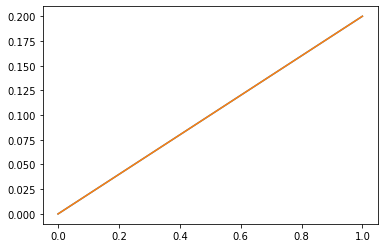

In [15]:
# check the inital
plt.figure()
plot(u1_0)
plot(u2_0)

In [16]:
# =========================================
# define functions

# Define variational problem
ddu1, ddu2 = TestFunction(V)

duvec = Function(V)
du1, du2 = split(duvec)

u1 = u1_0 + du1
u2 = u2_0 + du2
# weak form
F = inner(strain(u1),strain(ddu1))*dx + \
    (1/d_NonDim)*(fe_NonDim)*(1/wl_NonDim)*sin(2*pi/wl_NonDim*d_NonDim*(u1-u2))*ddu1*dx + \
    inner(strain(u2),strain(ddu2))*dx - \
    (1/d_NonDim)*(fe_NonDim)*(1/wl_NonDim)*sin(2*pi/wl_NonDim*d_NonDim*(u1-u2))*ddu2*dx

J = derivative(F, duvec)
problem = NonlinearVariationalProblem(F, duvec, bcs, J)
solver  = NonlinearVariationalSolver(problem)

In [17]:
prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-9
# prm['newton_solver']['relative_tolerance'] = 4E-8
# prm['newton_solver']['relative_tolerance'] = 1E-6
prm['newton_solver']['maximum_iterations'] = 100
prm['newton_solver']['relaxation_parameter'] = 0.5

------- Step: 0 , t = 0.04 -------
------- Step: 1 , t = 0.06 -------
------- Step: 2 , t = 0.08 -------
------- Step: 3 , t = 0.1 -------
------- Step: 4 , t = 0.12000000000000001 -------
------- Step: 5 , t = 0.14 -------
------- Step: 6 , t = 0.16 -------
------- Step: 7 , t = 0.18 -------
------- Step: 8 , t = 0.19999999999999998 -------
------- Step: 9 , t = 0.21999999999999997 -------
------- Step: 10 , t = 0.23999999999999996 -------
------- Step: 11 , t = 0.25999999999999995 -------
------- Step: 12 , t = 0.27999999999999997 -------
------- Step: 13 , t = 0.3 -------
------- Step: 14 , t = 0.32 -------
------- Step: 15 , t = 0.34 -------
------- Step: 16 , t = 0.36000000000000004 -------
------- Step: 17 , t = 0.38000000000000006 -------
------- Step: 18 , t = 0.4000000000000001 -------
------- Step: 19 , t = 0.4200000000000001 -------
------- Step: 20 , t = 0.4400000000000001 -------
------- Step: 21 , t = 0.46000000000000013 -------
------- Step: 22 , t = 0.48000000000000015 

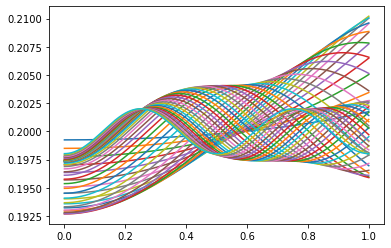

In [18]:
for i in range(N_STEPS):
# for i in range(2):
    # ---------------------------
    stepper.advance()
    
    print("------- Step: "+str(i)+" , t = "+str(stepper.tval)+" -------")
    solver.solve()
    uvec_0.vector()[:] = uvec_0.vector()+duvec.vector()
    
    # file << (uvec_0, stepper.tval)
    hdf.write(uvec_0, 'velocity', stepper.tval)
    # ---------------------------
    # for plot
    plot(strain(u1_0))
    plt.autoscale()
#     plt.xlim(0.0-0.05,1.0+0.05)
#     plt.ylim(0.0,d_NonDim+0.05)

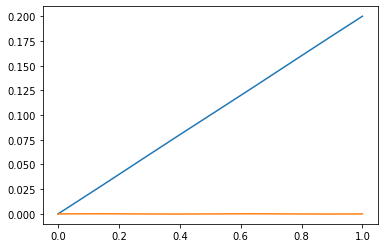

In [19]:
# final
# ------------------------------
plt.figure()
plot(u1_0)
plot(u2_0)

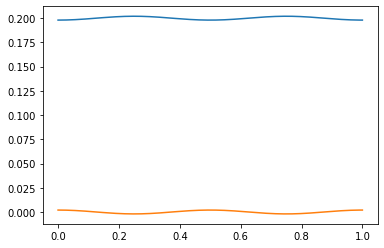

In [20]:
# final
# ------------------------------
plt.figure()
plot(strain(u1_0))
plot(strain(u2_0))
plt.autoscale()
# plt.xlim(0.0-0.05, 1.0+0.05)
# plt.ylim(0.0-0.05, d_NonDim+0.05)

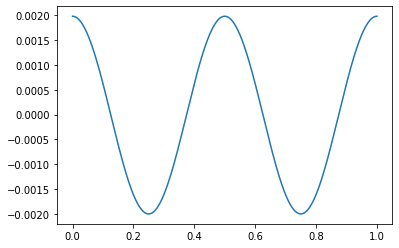

In [21]:
plt.figure()

plot(strain(u2_0))

In [24]:
# read back and process
# ==========================================
uvec_r1 = Function(V)
uvec_r2 = Function(V)

hdf = HDF5File(mesh.mpi_comm(), 'file.h5','r')
hdf.read(uvec_r1, 'velocity/vector_1')
hdf.read(uvec_r2, 'velocity/vector_40')

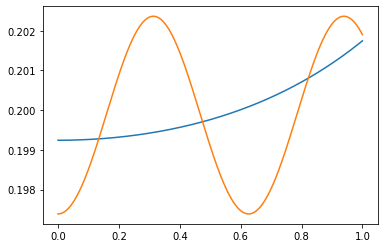

In [25]:
plt.figure()
plot(strain(uvec_r1.sub(0)))
plot(strain(uvec_r2.sub(0)))
plt.autoscale()

In [33]:
uvec_r = Function(V)

# hdf = HDF5File(mesh.mpi_comm(), 'file.h5','r')


for i in range(N_STEPS):
    read_name = 'velocity/vector_' + str(i)
    hdf.read(uvec_r, read_name)
    save_name1 = 'e22_bot_' + str(i)
    save_name2 = 'e22_top_' + str(i)
    
    fig = plt.figure()
    plt.xlim(0.0-0.05,1.0+0.05)
    plt.ylim(0.1925, 0.2100)
    plot(strain(uvec_r.sub(0)))
    plt.savefig(save_name1)
    plt.close(fig)
    
    fig = plt.figure()
    plt.xlim(0.0-0.05,1.0+0.05)
    plt.ylim(0.0, 0.2100)
    plot(strain(uvec_r.sub(1)))
    plt.savefig(save_name2)
    plt.close(fig)